# RNN 을 이용한 영화 리뷰 감정 분석
- 다음 명령어로 datasets 을 설치합니다.
    - datasets: HuggingFace community-driven open-source library of datasets
    - 이 [링크](https://huggingface.co/datasets) 에서 다양한 dataset 목록을 확인할 수 있습니다.
```bash
$ pip install datasets
```

In [17]:
import torch
from datasets import load_dataset

## IMDB dataset
- Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
- 다음 key 를 가진 dict 로 구성
    - `text`: a string feature.
    - `label`: a classification label, with possible values including neg (0), pos (1).
- [참고 링크](https://huggingface.co/datasets/stanfordnlp/imdb)

In [2]:
ds = load_dataset("stanfordnlp/imdb")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:
# data 형태 확인
print(type(ds["train"][0]), ds["train"][0].keys())
ds["train"][0]

<class 'dict'> dict_keys(['text', 'label'])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Tokenizer 만들기
### 사용할 Huggingface library 의 모듈
- decoders
    - 토큰화된 텍스트를 원래의 문자열로 되돌리는 디코더 관련 기능을 제공합니다.
    - 예를 들어, WordPiece나 BPE 디코딩 등을 수행할 수 있습니다.
- models
    - 토크나이저의 핵심 모델을 정의합니다. 
    - 여기에는 BPE (Byte-Pair Encoding), WordPiece, Unigram 등의 토크나이징 알고리즘이 포함됩니다.
- normalizers
    - 텍스트 정규화를 위한 기능을 제공합니다. 
    - 예를 들어, 소문자 변환, 악센트 제거, 유니코드 정규화 등을 수행할 수 있습니다.
- pre_tokenizers
    - 본격적인 토큰화 이전에 텍스트를 사전 처리하는 기능을 제공합니다.
    - 공백으로 분리하거나 정규표현식을 이용한 분리 등을 수행할 수 있습니다.
- processors
    - 토큰화 후 처리 단계를 담당합니다. 
    - 예를 들어, 특수 토큰 추가(예: [CLS], [SEP])나 템플릿 처리 등을 수행할 수 있습니다.
- trainers
    - 토크나이저를 학습시키기 위한 트레이너를 제공합니다.
    - 새로운 어휘를 학습하거나 기존 토크나이저를 fine-tuning 할 때 사용됩니다.
- Tokenizer
    - 실제 토크나이저 객체를 생성하고 관리하는 클래스입니다.
    - 위의 모든 구성 요소들을 조합하여 완전한 토크나이징 파이프라인을 구성합니다.

### Tokenizer 의 파이프라인
실제 토큰화 과정의 일반적인 순서는 아래와 같습니다.

1. Normalizers
    - 가장 먼저 적용됩니다.
    - 텍스트를 정규화합니다 (예: 소문자 변환, 악센트 제거 등).
2. Pre-tokenizers
    - 정규화된 텍스트를 초기 토큰으로 분리합니다.
    - 예를 들어, 공백으로 분리하거나 정규표현식을 사용할 수 있습니다.
3. Model
    - 실제 토큰화 알고리즘을 적용합니다 (예: BPE, WordPiece, Unigram 등).
    - Pre-tokenizer에서 나온 초기 토큰을 더 작은 단위로 분할할 수 있습니다.
4. Processors
    - 토큰화된 결과에 추가 처리를 적용합니다.
    - 예를 들어, 특수 토큰 추가 ([CLS], [SEP] 등) 또는 시퀀스 길이 제한 등을 수행합니다.
5. (필요시) Decoder
    - 토큰화된 텍스트를 원래 형태로 되돌리는 데 사용됩니다.
    - 주로 모델 출력을 해석할 때 사용됩니다.


In [4]:
from tokenizers import models, normalizers, pre_tokenizers, trainers, Tokenizer

In [5]:
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

In [6]:
tokenizer.normalizer = normalizers.BertNormalizer(
    lowercase=True
)  # lowercase=True 를 함으로써, 모든 텍스트를 소문자로 변환
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

### Custom Tokenizer 학습

In [7]:
def get_training_corpus():
    """
    ds 데이터를 1000 개씩 제공하는 generator
    """
    for i in range(0, len(ds["train"]), 1000):
        yield ds["train"][i : i + 1000]["text"]


special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]"]
trainer = trainers.WordPieceTrainer(vocab_size=10_000, special_tokens=special_tokens)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [8]:
# 학습 결과
tokenizer.encode("Hello, world!")

Encoding(num_tokens=4, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

## Huggingface 의 Transformers 패키지
- Transformers는 Hugging Face에서 개발한 오픈 소스 라이브러리입니다.

### 목적

- 자연어 처리(NLP) 태스크를 위한 최신 사전 학습 모델들을 쉽게 사용할 수 있게 해줍니다.
- BERT, GPT, RoBERTa, T5 등 다양한 트랜스포머 기반 모델을 지원합니다.


### 주요 특징

- 3,000개 이상의 사전 학습된 모델을 제공합니다.
- PyTorch, TensorFlow, JAX와 같은 주요 딥러닝 프레임워크를 지원합니다.
- 모델 학습, 미세 조정, 추론 등 전체 NLP 파이프라인을 지원합니다.


### 사용 편의성

- 모델 로딩, 토큰화, 추론 등을 몇 줄의 코드로 수행할 수 있습니다.
- Auto 클래스를 통해 모델 아키텍처에 구애받지 않는 코드 작성이 가능합니다.


### 확장성

- 커스텀 모델과 태스크를 쉽게 추가할 수 있습니다.
- 대규모 데이터셋 처리를 위한 도구를 제공합니다.

### 설치

- 기본 설치
    터미널이나 명령 프롬프트에서 다음 명령어를 실행합니다.
    
    ```
    pip install transformers
    ```

- 일반적으로 Transformers를 사용할 때 함께 사용되는 라이브러리들을 포함하여 설치하는 것이 좋습니다.
    이 명령어는 PyTorch와 SentencePiece를 함께 설치합니다.

    ```
    pip install "transformers[torch,sentencepiece]"
    ```

In [9]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

/Users/joyuiyeong/.pyenv/versions/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# tokenizing 예시
text_list = ["Hello, world!", "Nice to meet you! 😁"]
tokens = tokenizer(text_list, padding=True)
tokens.input_ids

[[8694, 15, 744, 4, 1, 1], [1089, 166, 2016, 225, 4, 0]]

## Tokenizer의 vocabulary 와 그 길이의 중요성

### Vocabulary의 의미
- Vocabulary(어휘)는 tokenizer가 인식하고 처리할 수 있는 모든 고유한 토큰(단어, 부분 단어, 문자 등)의 집합입니다.
- 이는 모델이 이해하고 생성할 수 있는 '단어'들의 전체 목록이라고 생각할 수 있습니다.
- BERT 스타일 tokenizer의 경우, 이는 전체 단어, 부분 단어(subword), 그리고 개별 문자를 포함할 수 있습니다.

### Vocabulary 길이의 의미
- `len(tokenizer)`는 이 vocabulary에 포함된 고유한 토큰의 총 개수를 반환합니다.
- 예를 들어, 길이가 30,000이라면 tokenizer가 30,000개의 서로 다른 토큰을 인식할 수 있다는 의미입니다.

### Vocabulary 길이를 알아야 하는 이유
a) 모델 구조 설정
  - 많은 NLP 모델, 특히 transformer 기반 모델에서는 입력 임베딩 레이어의 크기를 vocabulary 크기에 맞춰야 합니다.
  - 모델의 출력 레이어 또한 종종 vocabulary 크기와 일치해야 합니다(예: 언어 모델링 태스크).

b) 모델 성능 예측
  - Vocabulary 크기는 모델의 복잡도와 학습 난이도에 영향을 줍니다.
  - 너무 작으면 모델의 표현력이 제한될 수 있고, 너무 크면 학습이 어려워질 수 있습니다.

c) 메모리 사용량 예측
  - Vocabulary 크기는 모델의 메모리 사용량에 직접적인 영향을 미칩니다.
  - 특히 임베딩 레이어의 크기를 결정하는 주요 요소입니다.

d) OOV(Out-of-Vocabulary) 처리
  - Vocabulary 크기를 알면 OOV 토큰의 처리 방식을 결정하는 데 도움이 됩니다.
  - 예를 들어, Vocabulary가 작다면 OOV 문제가 더 자주 발생할 수 있으므로 이에 대한 전략이 필요합니다.

e) 토큰 ID 범위 확인
  - 토큰화된 입력의 유효성을 검사할 때 유용합니다.
  - 모든 토큰 ID는 0부터 `len(tokenizer) - 1` 사이의 값이어야 합니다.

In [11]:
print("tokenizer 의 사전 크기:", len(tokenizer))

tokenizer 의 사전 크기: 10001


In [12]:
print("tokenizer 의 unk_token:", tokenizer.unk_token, "| id:", tokenizer.unk_token_id)
print("tokenizer 의 pad_token:", tokenizer.pad_token, "| id:", tokenizer.pad_token_id)
print("tokenizer 의 cls_token:", tokenizer.cls_token, "| id:", tokenizer.cls_token_id)
print("tokenizer 의 sep_token:", tokenizer.sep_token, "| id:", tokenizer.sep_token_id)

tokenizer 의 unk_token: [UNK] | id: 0
tokenizer 의 pad_token: [PAD] | id: 1
tokenizer 의 cls_token: [CLS] | id: 2
tokenizer 의 sep_token: [SEP] | id: 3


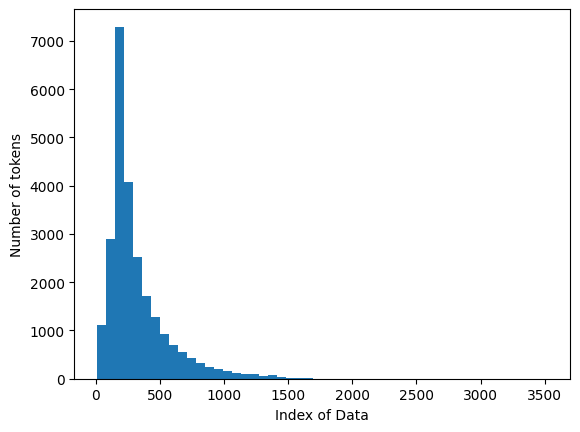

In [13]:
from matplotlib import pyplot as plt

num_tokens_by_data = []
for row in ds["train"]:
    ids = tokenizer(row["text"]).input_ids
    num_tokens_by_data.append(len(ids))

plt.ylabel("Number of tokens")
plt.xlabel("Index of Data")
plt.hist(num_tokens_by_data, bins=50)
plt.show()

In [14]:
print("평균 token 개수:", sum(num_tokens_by_data) / len(num_tokens_by_data))

평균 token 개수: 323.03248


## Dataloader 만들기
- text data 와 같은 data 는 입력이 가변적이기 때문에 collate_fn 인자에 함수를 넣어주어 같은 shpae 을 같도록 만들어야 합니다.
- collate_fn
    - 배치(batch)를 만들 때 개별 데이터 샘플들을 어떻게 결합할지 정의합니다.
    - 기본 collate_fn은 단순히 텐서들을 스택(stack)하는데, 이는 가변 길이 시퀀스에 적합하지 않습니다.
- 텍스트 데이터에서 collate_fn이 필요한 이유
    - 리뷰 텍스트의 길이가 다양합니다.
    - 토큰화된 시퀀스를 동일한 길이로 만들어야 합니다(패딩).
    - 배치 내의 텐서들이 동일한 형태(shape)를 가져야 합니다.

In [23]:
from torch.utils.data import DataLoader


def collate_imdb(batch):
    max_length = 400

    texts, labels = [], []
    for r in batch:
        labels.append(r["label"])
        texts.append(r["text"])

    texts_tensor = torch.LongTensor(
        tokenizer(texts, padding=True, truncation=True, max_length=max_length).input_ids
    )
    labels_tensor = torch.LongTensor(labels)
    return texts_tensor, labels_tensor


train_data_loader = DataLoader(
    ds["train"], batch_size=64, shuffle=True, collate_fn=collate_imdb
)
test_data_loader = DataLoader(
    ds["test"], batch_size=64, shuffle=False, collate_fn=collate_imdb
)

In [24]:
ex_text, ex_label = next(iter(train_data_loader))
print(ex_text.shape, ex_label.shape)

torch.Size([64, 400]) torch.Size([64])
